# Import package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history
import math
from typing import List, Tuple

# Import Data

In [ ]:
# Solomon datasets
# 25 Customers
# rc101 data sets
distance = (
    pd.read_excel(
        r"C:\rl-meta-test\src\Source\MSIE_datasets\rc101_25customers_datasets.xlsx",
        sheet_name="distance",
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(
        r"C:\rl-meta-test\src\Source\MSIE_datasets\rc101_25customers_datasets.xlsx",
        sheet_name="vehicle",
    )
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(
    r"C:\rl-meta-test\src\Source\MSIE_datasets\rc101_25customers_datasets.xlsx",
    sheet_name="customer",
).iloc[:, 3:]


demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, 3].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

# Evaluating objective function

In [10]:
def preserving_strategy(X, V, **kwargs):
    # --- Unpack input data from keyword arguments ---
    dist = kwargs["distance"]  # Distance/time matrix between all nodes
    weight = kwargs["demand"]  # Demand (weight) for each customer node
    ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
    due = kwargs["dueDate"]  # Due time (latest service time) for each node
    service = kwargs["serviceTime"]  # Service time at each node
    vehicle = kwargs[
        "vehicle"
    ]  # Vehicle info: [number of vehicles, capacity per vehicle]

    # Get per-vehicle capacities (by indexing with V)
    pre_w_cap = np.array([vehicle[1]] * vehicle[0])
    w_cap = pre_w_cap[V]

    # -- Initialization --
    sequence = X  # Route sequence (includes depot at start & end)
    n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
    n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
    i, k = 0, 0  # i: current position in sequence, k: vehicle index
    total_distance = 0  # Store total traveled distance (with penalty if any)

    # -- Main loop over each vehicle route --
    while k <= n_veh and i <= n_cust:
        # Initialize per-route accumulators
        route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

        if k > 0:
            i += 1  # Move to the next start customer for the next vehicle
        # Start route: depot to first customer
        route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
        route_time += (
            service[0] + dist[0][sequence[i]]
        )  # Service + travel time to first customer
        weight_load += weight[sequence[i]]  # Initial cargo: first customer demand

        if route_time < ready[sequence[i]]:
            route_time = ready[
                sequence[i]
            ]  # Wait if vehicle arrives before ready time

        if route_time > due[sequence[i]] or weight_load > w_cap[k]:
            penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
            break

        # --- Continue visiting customers along this route ---
        while i <= n_cust:
            route_dist += dist[sequence[i]][
                sequence[i + 1]
            ]  # Add next leg distance

            route_time += (
                service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
            )  # Add service + travel time

            weight_load += weight[sequence[i + 1]]  # Add new customer demand

            if route_time < ready[sequence[i + 1]]:
                route_time = ready[
                    sequence[i + 1]
                ]  # Wait if arrive early at next node

            # If time window or capacity violated, backtrack and finish route
            if route_time > due[sequence[i + 1]] or weight_load > w_cap[k]:
                route_dist -= dist[sequence[i]][sequence[i + 1]]
                route_time -= (
                    service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                )
                weight_load -= weight[sequence[i + 1]]
                break
            i += 1

        # --- Finish by returning to depot ---
        route_dist += dist[sequence[i]][0]  # Add distance to depot
        route_time += (
            service[sequence[i]] + dist[sequence[i]][0]
        )  # Add service at last node + travel to depot
        if route_time > due[0]:
            penaltyCost += 1e11  # Penalty: returned to depot too late
        # Accumulate this route's total (distance + penalty if any)
        total_distance += route_dist + penaltyCost
        k += 1  # Next vehicle

    return total_distance  # Return overall objective (distance with penalty if violated)

# --------------------------
# Thin wrapper to call the evaluator
# --------------------------
def f_per_particle(m, s, **kwargs):
    X = m  # decoded sequence
    V = s  # decoded vehicle vector
    obj_val = preserving_strategy(X, V, **kwargs)  # Call Preserving strategy.
    return obj_val

# --------------------------
# Decode a chromosome to (sequence, vehicle) and evaluate
# --------------------------
def objective_func(x, **kwargs):
    vehicle = kwargs["vehicle"]
    # First block → customer order (rank-based decoding): smaller value → earlier visit
    seq = x[:,:-vehicle[0]].argsort(axis=1) + 1 
    # Last 'num_vehicles' genes → vehicle order/index (again rank-based)
    sort = x[:,-vehicle[0]:].argsort(axis=1)
    j = [f_per_particle(seq[i], sort[i], **kwargs) for i in range(n_particles)]
    return np.array(j)

# PSO algorithm

In [11]:
# Set-up hyperparameters
options = {"c1": 0.9, "c2": 0.5, "w": 0.3}

n_particles = 400
dimensions = len(distance) - 1 + vehicle[0]
iters = 1000

In [12]:
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles, dimensions=dimensions, options=options
)

# Perform optimization
cost, pos = optimizer.optimize(objective_func, iters=iters, **kwargs)

2025-11-17 16:01:25,665 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.9, 'c2': 0.5, 'w': 0.3}
pyswarms.single.global_best:   0%|          |0/1000

pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=820 
2025-11-17 16:02:19,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 820.4833679851105, best pos: [0.66490043 0.52882731 0.53404889 0.5450325  0.7362534  0.74147033
 0.29007351 0.27798288 0.44924719 0.91523942 0.88556481 0.80215829
 0.94187674 0.79110021 0.71148245 0.66757575 0.94224308 0.50988222
 0.36729744 0.73360254 0.39884749 0.4153056  0.46130663 0.52840681
 0.71516473 0.4471185  0.76632239 0.39457847 0.30466398 0.49255027
 0.55368835 0.70730703 0.78476993 0.62188863 0.37868875 0.41618732
 0.61555164 0.46457803 0.3697298  0.51930889 0.38095041 0.636751
 0.72108947 0.88606244 0.44673316 0.30756845 0.54457746 0.40903728
 0.5537085  0.49356324]


In [13]:
cost

820.4833679851105

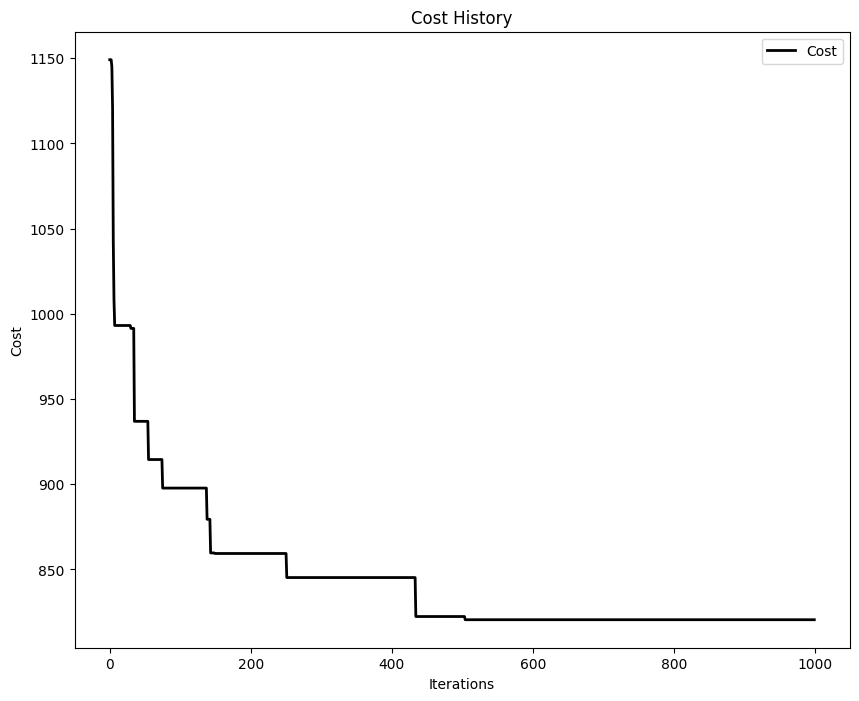

In [14]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [33]:
vrptw_input_params = "rc202_25"
# 25 Customers
# C101
if vrptw_input_params == "c101_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\c101_25_customers.xlsx"
# C102
elif vrptw_input_params == "c102_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\c102_25_customers.xlsx"
# C201
elif vrptw_input_params == "c201_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\c201_25_customers.xlsx"
# C202
elif vrptw_input_params == "c202_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\c202_25_customers.xlsx"
# r101
elif vrptw_input_params == "r101_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\r101_25_customers.xlsx"
# r102
elif vrptw_input_params == "r102_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\r102_25_customers.xlsx"
# r201
elif vrptw_input_params == "r201_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\r201_25_customers.xlsx"
# r202
elif vrptw_input_params == "r202_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\r202_25_customers.xlsx"
# rc101
elif vrptw_input_params == "rc101_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\rc101_25_customers.xlsx"
# rc102
elif vrptw_input_params == "rc102_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\rc102_25_customers.xlsx"
# rc201
elif vrptw_input_params == "rc201_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\rc201_25_customers.xlsx"
# rc202
elif vrptw_input_params == "rc202_25":
    excel_file = r"C:\rl-meta-test\src\Source\MSIE_datasets\rc202_25_customers.xlsx"
else:
    raise ValueError("Invalid problem_set. Choose either 'SMALL' or 'LARGE'.")

# Load distance data
df_distance = pd.read_excel(excel_file, sheet_name="distance")
distance = df_distance.fillna(9999999).to_numpy()

# Load vehicle data
df_vehicle = pd.read_excel(excel_file, sheet_name="vehicle")
vehicle = df_vehicle.loc[0, "fleet_size":"fleet_capacity"].values

# Load customer data
df_customer = pd.read_excel(excel_file, sheet_name="customer")
demand = df_customer.loc[:, "demand"].to_numpy()
readyTime = df_customer.loc[:, "readyTime"].to_numpy()
dueDate = df_customer.loc[:, "dueTime"].to_numpy()
serviceTime = df_customer.loc[:, "duration"].to_numpy()
dimensions = distance.shape[0] - 1 + vehicle[0]
